## Esse programa cria uma série temporal de inundação


# 1. Importação das bibliotecas


In [6]:
import ee
import datetime as dt
import pandas as pd
import fiona
import os

## Inicializa o Earth Engine

In [2]:
ee.Initialize()

## Definir o input dos dados

In [3]:
Geom = r"C:\Users\Edson\Documents\MEGAsync\ser\ser300\proj_geoprocessamento\lago.shp"  # Poligono da área a ser analisada
#  Nesse exemplo, será utilizado para o Lago Grande do Curuai (Pará)
DateStart = (2003, 1, 1)  # Data inicial a série temporal
DateEnd = (2004, 12, 30)  # Data final da série temporal
ResTemp = 10  # Resolução temporal da série temporal (dias para fazer o mosaico)
Escala = 500  # Escala espacial
Proj = 'EPSG:4326'
SaveImg = False # (True ou False) Diz se salva as imagens no drive ou não

# 2. Gera variáveis secundarias e funções para o processamento

In [4]:
Poligono = fiona.open(Geom)
PoliProj = Poligono.crs['init']
Coord = [list(x) for x in [x['geometry']['coordinates'] for x in Poligono][0][0]]
Area = ee.Geometry.Polygon(Coord, PoliProj)
region = Area.getInfo()['coordinates']  # Define o input para salvar as imagens

# Gera o DataFrame para salvar os resultados da série temporal
DateStartT = dt.datetime(DateStart[0], DateStart[1], DateStart[2])
DateEndT = dt.datetime(DateEnd[0], DateEnd[1], DateEnd[2])
index = pd.date_range(DateStartT, DateEndT, freq=str(ResTemp) + 'D')
header = ['Cobertura_Válida', 'Water_cover (km²)']
Data = pd.DataFrame( {}, index = index, columns = header)


def getqabits(image, start, end, newname):
    pattern = 0
    for i in list(range(start, end+1)):
        pattern += 2**i
        return image.select([0], [newname]).bitwiseAnd(pattern).rightShift(start)


# 3. Inicio dos cálculos

In [5]:
for date in index:  # Controla a data inicial da composição
    image = ee.Image('MODIS/006/MYD09GA/' + date.isoformat()[0:10].replace('-', '_')) # Imagem inicial da composição
    NDWI = image.expression('(Verde - NIR) / (Verde + NIR)',
                            dict(NIR=image.select('sur_refl_b02'), Verde=image.select('sur_refl_b04')))

    cloud = getqabits(image.select('state_1km'), 0, 1, 'cloud_state')
    cloud = cloud.expression("b(0) == 1 || b(0) == 2")
    pixel_valido = cloud.expression("b(0) == 0")

    agua = NDWI.expression("b(0) > 0").mask(pixel_valido)
    
    # Condição se a resolução temporal é maior que um dia, fazer o mosaico
    if ResTemp > 1:
        mosaico = pd.date_range(dt.datetime(date.year, date.month, date.day), periods=ResTemp)[1:]
        for composicao in mosaico:  # controla a intesecção dos dias no mosaico.
            image2 = ee.Image('MODIS/006/MYD09GA/' + composicao.isoformat()[0:10].replace('-', '_'))  # Imagem a ser
            # adicionada no mosaico

            NDWI2 = image2.expression('(Verde - NIR) / (Verde + NIR)',
                                      dict(NIR=image2.select('sur_refl_b02'), Verde=image2.select('sur_refl_b04')))

            cloud2 = getqabits(image2.select('state_1km'), 0, 1, 'cloud_state')
            cloud2 = cloud2.expression("b(0) == 1 || b(0) == 2")
            pixel_valido2 = cloud2.expression("b(0) == 0")

            agua2 = NDWI2.expression("b(0) > 0").mask(pixel_valido2)

            agua = ee.Image([agua.select(0), agua2.select(0)])

            pixel_valido = ee.Image([pixel_valido.select(0), pixel_valido2.select(0)])

            agua = agua.reduce(ee.Reducer.max())  # obtem o valor máximo da composicao, ou seja, se apenas uma vez foi
            # inundada
            pixel_valido = pixel_valido.reduce(ee.Reducer.max())  # obtem o máximo da composicao, ou seja, se ja ocorreu
            # alguma vez pixel válido
    
    #  Condição para reprojetar a imagem
    if Proj != False:
        agua = agua.reproject(Proj, None, Escala)
        pixel_valido = pixel_valido.reproject(Proj, None, Escala)

    cobertura_agua = agua.reduceRegion(reducer='sum', geometry = Area, scale = Escala) #Soma dos pixels da imagem inundada
    cobertura_valida = pixel_valido.reduceRegion(reducer='mean', geometry = Area, scale = Escala) #Média da cobertura válida

    Data.loc[date]['Cobertura_Válida'] = cobertura_valida.getInfo()['max'] * 100 #  cálculo da percentagem da
    #área de pixels válidos
    Data.loc[date]['Water_cover (km²)'] = (cobertura_agua.getInfo()['max']*(Escala**2)) / (1000**2) #  cálculo
    # da área coberta por água no mosaico

    
    #Condição para salvar a imagem
    if SaveImg == True:
        task_config = dict(description='Agua', region=region)
        task = ee.batch.Export.image(agua, 'Agua' + date.strftime("%Y-%m-%d"), task_config)
        task.start()

        task_config = {
            'description': 'Pixel_validos',
            'region': region
        }
        task = ee.batch.Export.image(pixel_valido, 'P_valido' + date.strftime("%Y-%m-%d"), task_config)
        task.start()


# Salvar a série temporal em um csv

In [8]:
os.listdir()

['.git',
 '.gitattributes',
 '.ipynb_checkpoints',
 'Apresentação.ipynb',
 'Serie_inundacao.py']

In [9]:
Data.to_csv('Agua' + DateStartT.strftime("%Y-%m-%d") + 'to' + DateEndT.strftime("%Y-%m-%d") + '.csv')

In [10]:
os.listdir()

['.git',
 '.gitattributes',
 '.ipynb_checkpoints',
 'Agua2003-01-01to2004-12-30.csv',
 'Apresentação.ipynb',
 'Serie_inundacao.py']

# 4. Gerar gráficos

### Primeiro, um exemplo desconsiderando a cobertura válida

Text(0,0.5,'Área Inundada (km )')

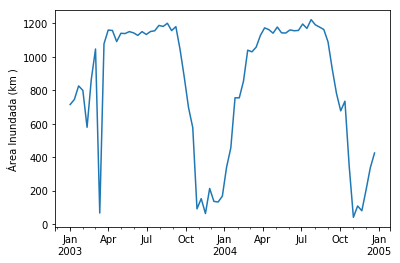

In [68]:
import matplotlib.pyplot as plt
Data['Water_cover (km²)'].plot()
plt.ylabel('Área Inundada (km )')

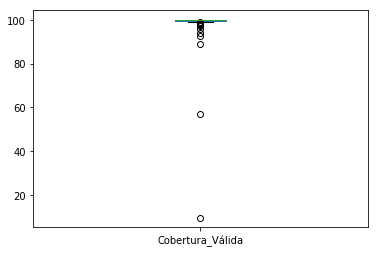

In [23]:
Data['Cobertura_Válida'].plot(kind='box')

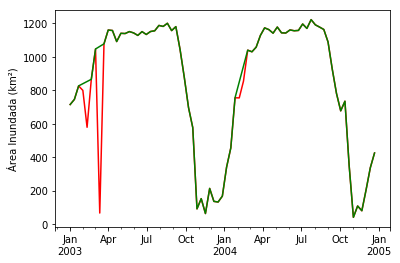

In [79]:
DataFil = Data[Data['Cobertura_Válida'] > 95] #  Filtra para periodos acima de 95% de pixels válidos
ax1 = Data['Water_cover (km²)'].plot(color = 'red')
plt.ylabel('Área Inundada (km²)')
DataFil['Water_cover (km²)'].plot(ax = ax1, color = 'green')